# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

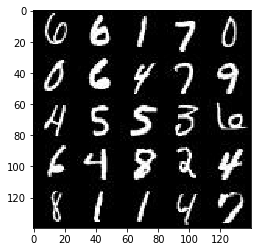

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

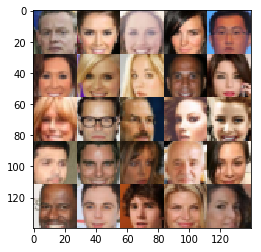

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learn_rate')
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    drop = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #input is 28*28*1
        initializer = tf.contrib.layers.xavier_initializer_conv2d(True, None, dtype=tf.float32)
        x = tf.layers.conv2d(images, 64, 4, strides=2, padding='same', kernel_initializer=initializer)
        x = x + tf.random_normal(shape = tf.shape(x), mean=0, stddev=0.05, dtype=tf.float32)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.layers.dropout(x, rate=drop)
        x = tf.maximum(x*alpha, x)
        
        x1 = tf.layers.conv2d(x, 128, 4, strides=2, padding='same')
        x1 = x1 + tf.random_normal(shape = tf.shape(x1), mean=0, stddev=0.05, dtype=tf.float32)
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.layers.dropout(x1, rate=drop)
        x1 = tf.maximum(x1*alpha, x1)
        
        x2 = tf.layers.conv2d(x1, 256, 4, strides=2, padding='same')
        x2 = x2 + tf.random_normal(shape = tf.shape(x2), mean=0, stddev=0.05, dtype=tf.float32)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.layers.dropout(x2, rate=drop)
        x2 = tf.maximum(x2*alpha, x2)
        
        x3 = tf.reshape(x2, (-1, 256))
        logits = tf.layers.dense(x3, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.1
    drop = 0.1
    
    with tf.variable_scope('generator', reuse=not is_train):
        initializer = tf.contrib.layers.xavier_initializer_conv2d(True, None, dtype=tf.float32)
        x = tf.layers.dense(z, 3*3*512, kernel_initializer = initializer)
        x = tf.reshape(x, (-1, 3, 3, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(x, rate=drop)
        x = tf.maximum(alpha*x, x)
        
        x2 = tf.layers.conv2d_transpose(x, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.layers.dropout(x2, rate=drop)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.layers.dropout(x3, rate=drop)
        x3 = tf.maximum(alpha*x3, x3)
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
    
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #tf.reset_default_graph()
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(56, z_dim))

    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
              

                if steps % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')

        print('Done!')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 1.1476
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.8786


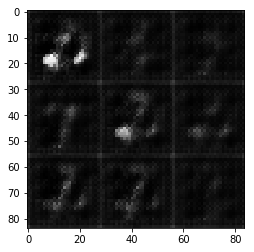

Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.8124
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.8156
Epoch 1/2... Discriminator Loss: 1.3605... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.3642... Generator Loss: 0.8145


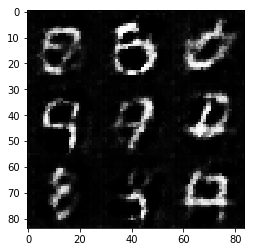

Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.8169
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.8082
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.8217
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.8112


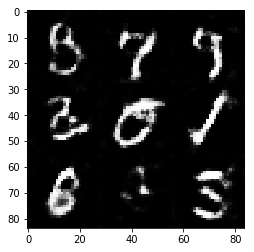

Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 1.3862... Generator Loss: 0.8139
Epoch 1/2... Discriminator Loss: 1.3624... Generator Loss: 0.8078


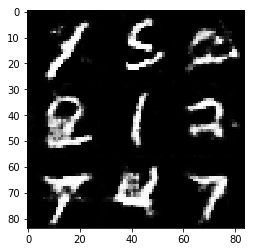

Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.8160
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.8173
Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.8044


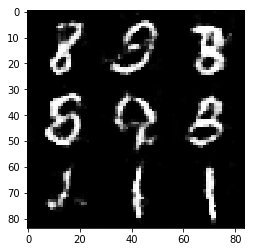

Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.8050
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 0.8187


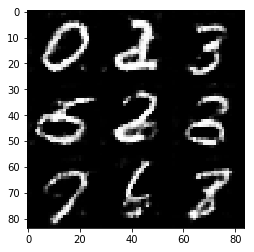

Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.8083
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.8007
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.8148
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.8001


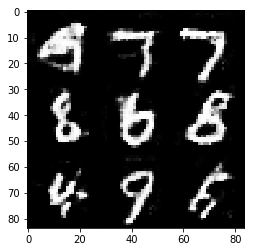

Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 0.8218
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.8167
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.8068
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.8090


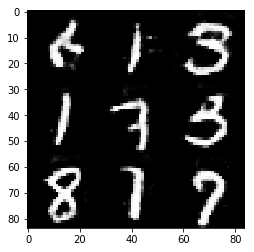

Epoch 2/2... Discriminator Loss: 1.3575... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.8126
Epoch 2/2... Discriminator Loss: 1.3772... Generator Loss: 0.8378


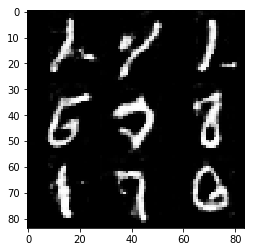

Epoch 2/2... Discriminator Loss: 1.3515... Generator Loss: 0.7980


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.1563
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.0079
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7614


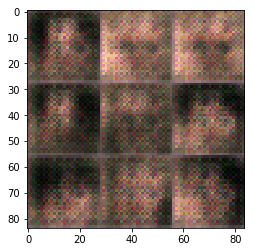

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8280


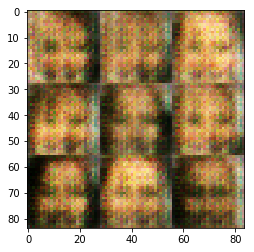

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8066


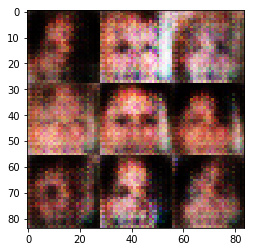

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7793


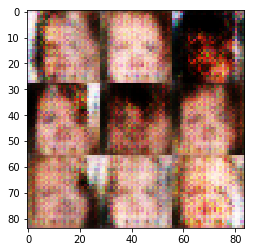

Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7970


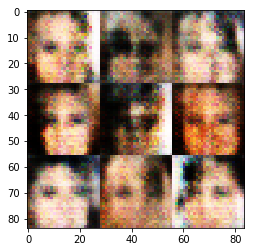

Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7772


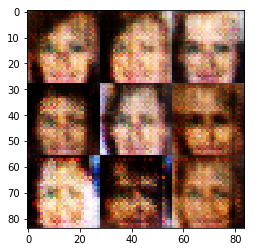

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7876


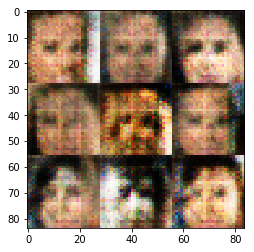

Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7974
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8077


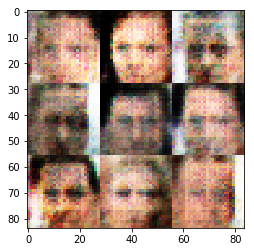

Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7903


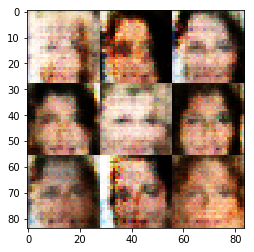

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8073


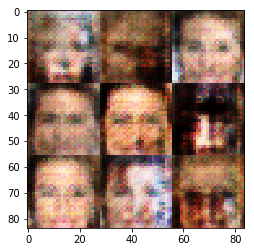

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7966


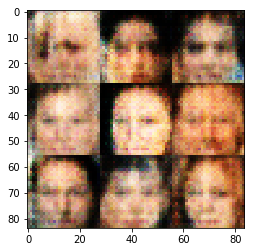

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7867


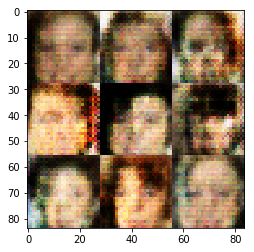

Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7928


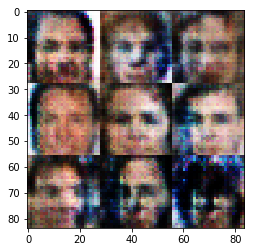

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7789


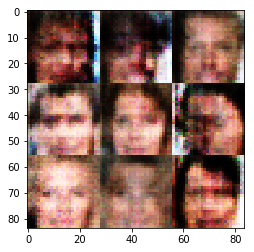

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8052


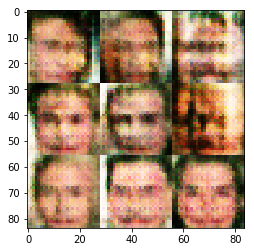

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8012


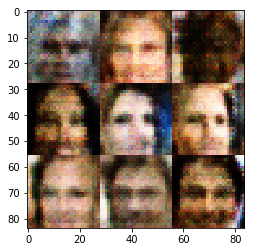

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7959


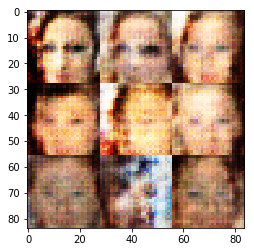

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7883


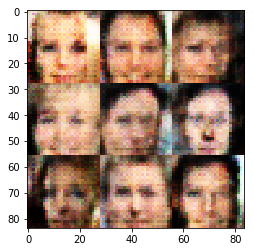

Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7959


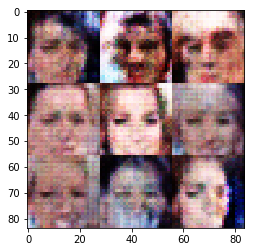

Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.7864


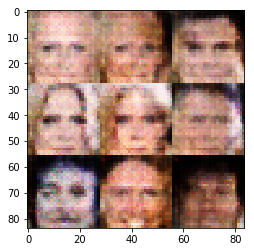

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3547... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7759


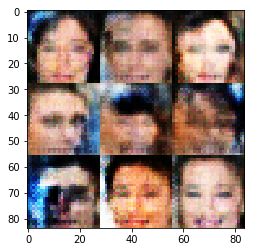

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7965


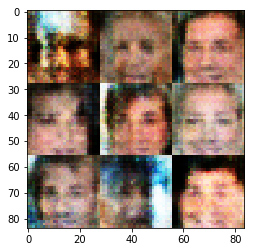

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8018


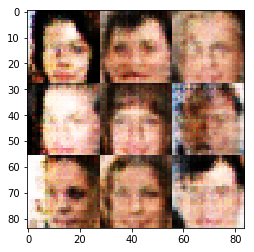

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7969


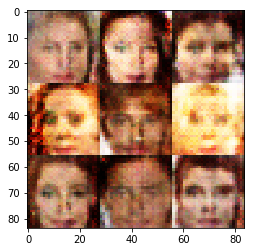

Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7735


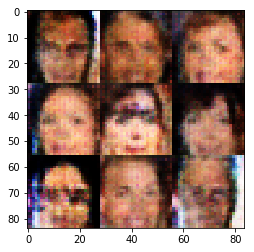

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7923


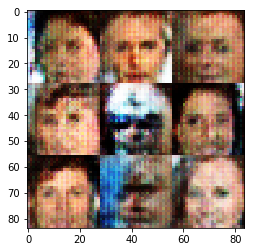

Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8083


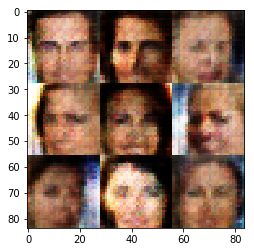

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7977
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7835


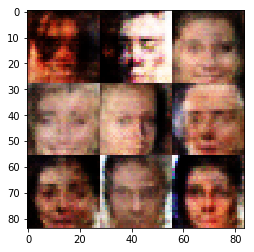

Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8072


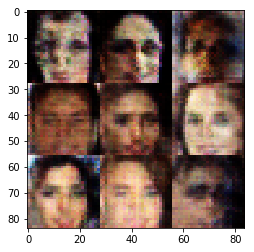

Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7945


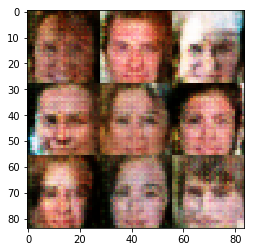

Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7850


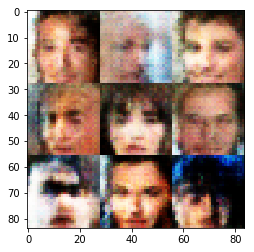

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8069


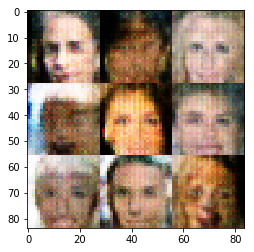

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7822


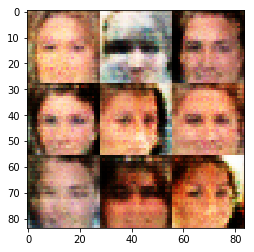

Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7925


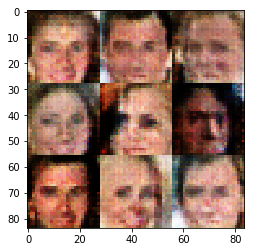

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.7917


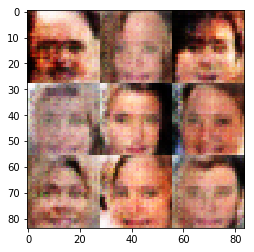

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7815


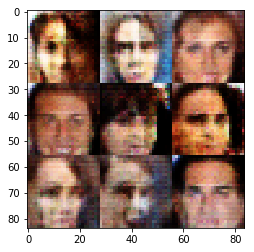

Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8067


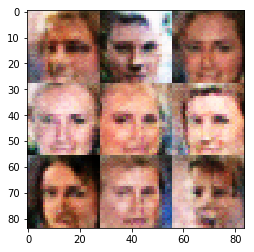

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7828


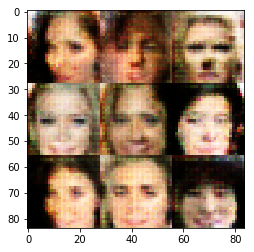

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8049


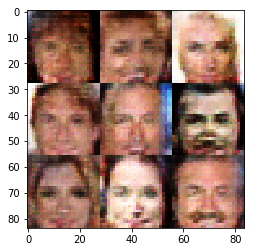

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7869


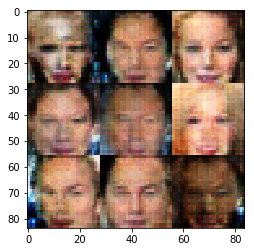

Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7915


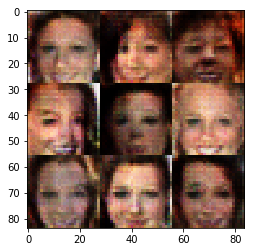

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.7789


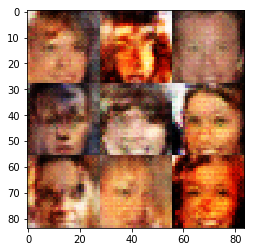

Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8119


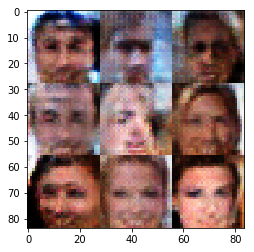

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.8098


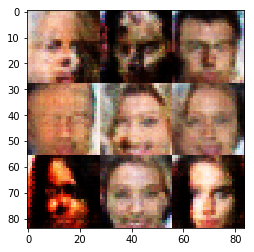

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8045


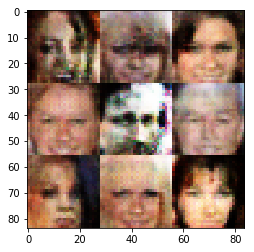

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7894


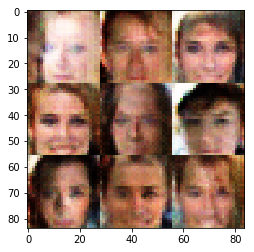

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7943


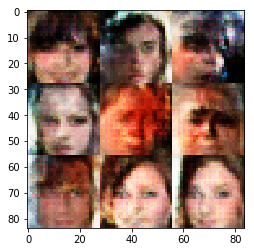

Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7829


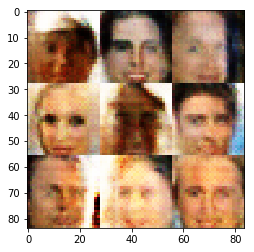

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.7927


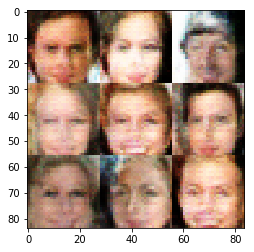

Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7978


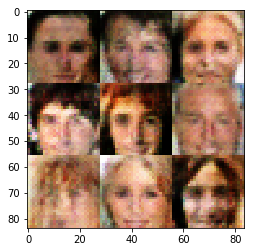

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8073


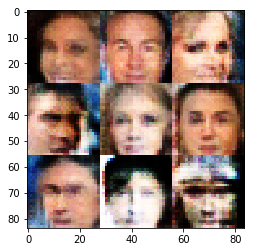

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8017
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7945


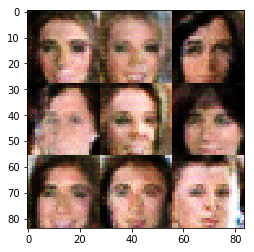

Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7835


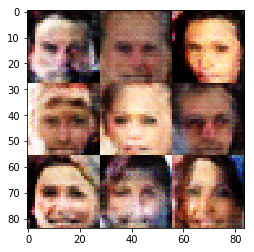

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7815


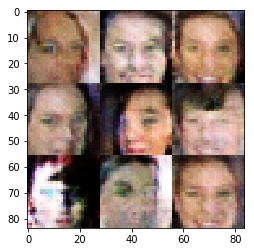

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.8008


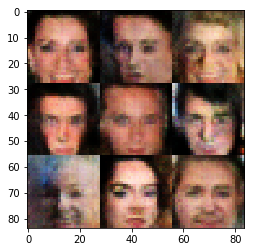

Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7799


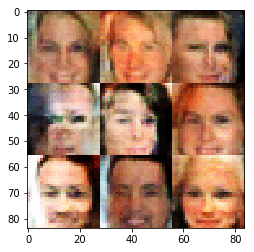

Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7907


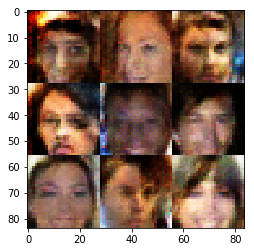

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8031


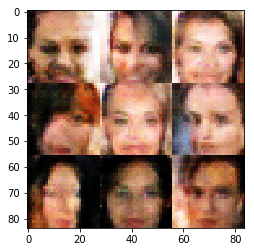

Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7955


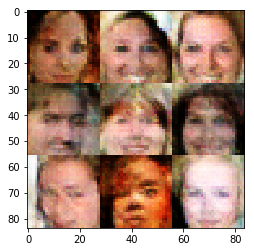

Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8018


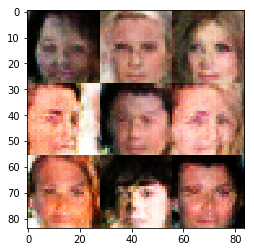

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.7925


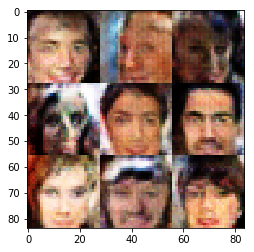

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7881


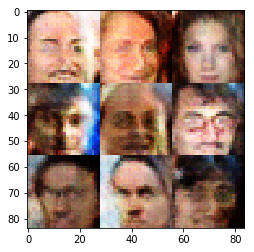

Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7961


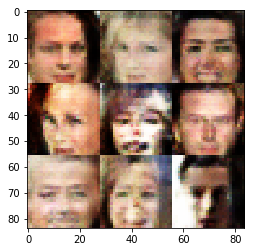

Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7899


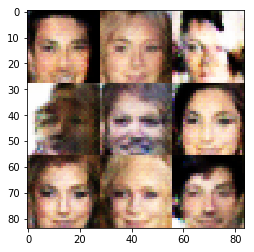

Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7896


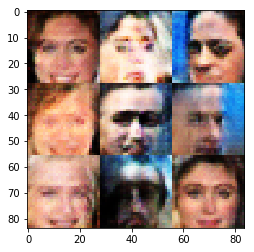

Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7888


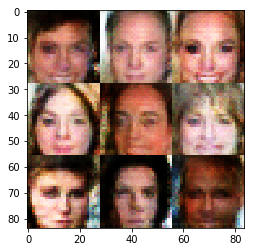

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7865


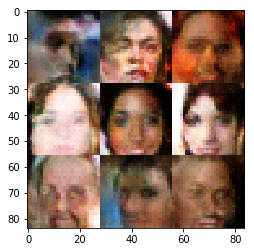

Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.7859


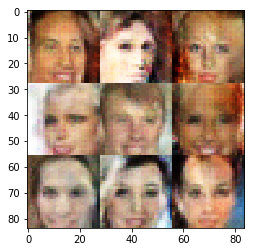

Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7898


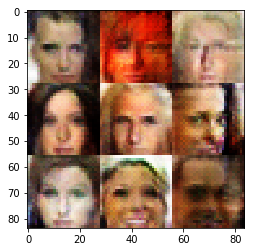

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7745


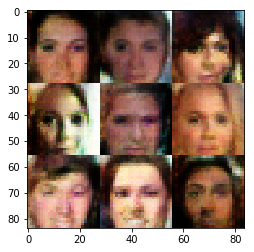

Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7710


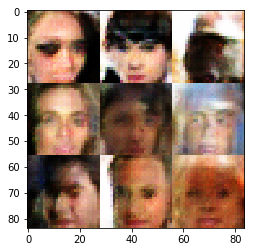

Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.7983


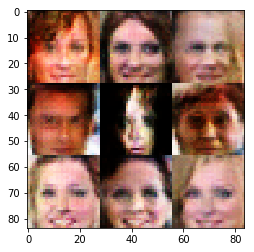

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8104


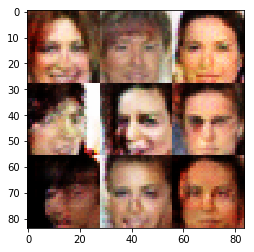

Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.7903


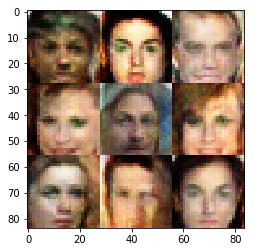

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7868
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7898


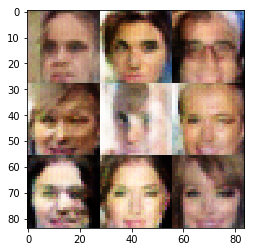

Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7980


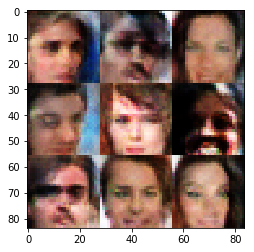

Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7946


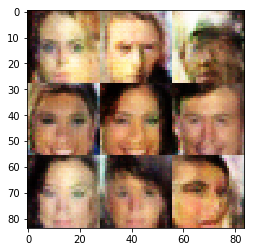

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7988


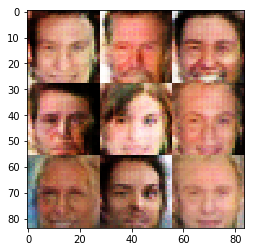

Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.8143


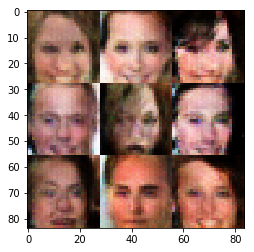

Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7882


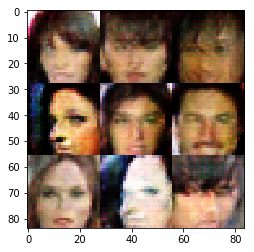

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7883


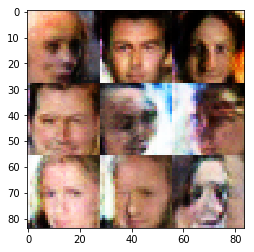

Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.8096


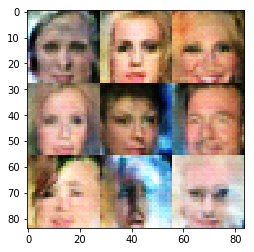

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7545


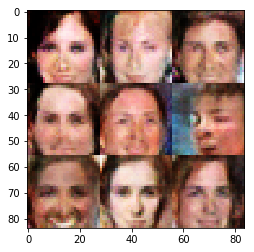

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.7759


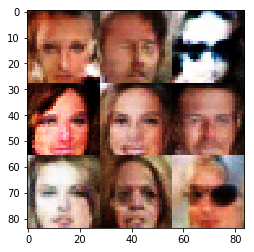

Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.8054


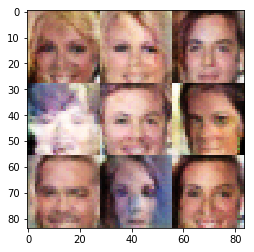

Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8009


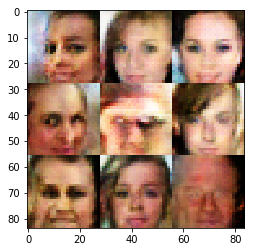

Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8193


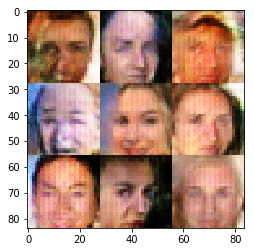

Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 0.8027
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7722


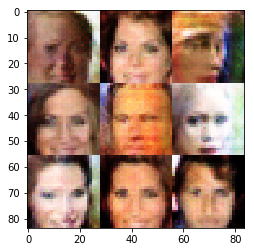

Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7803


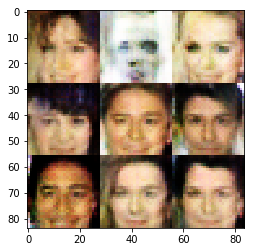

Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7880


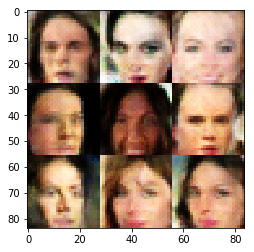

Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7924


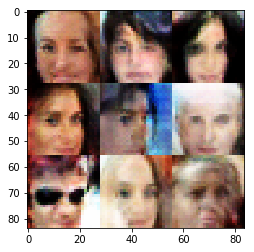

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7790


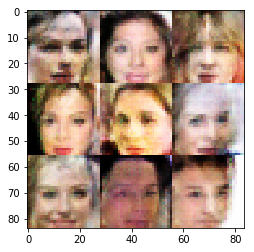

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7795


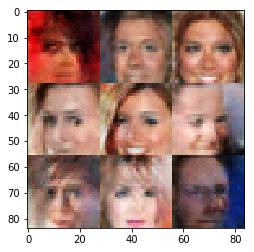

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.7698
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7953


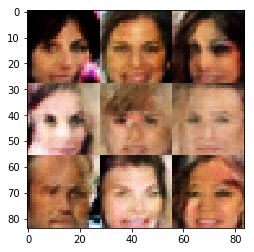

Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7877


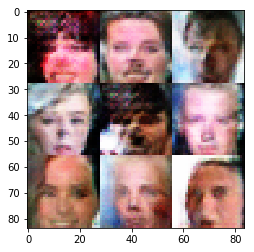

Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7902


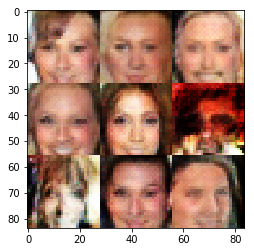

Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8111


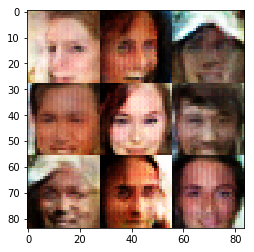

Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8024


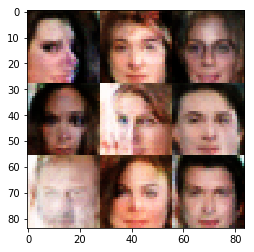

Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7940


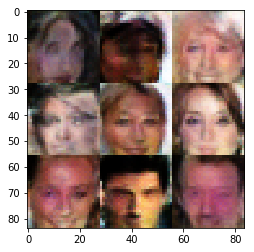

Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7674


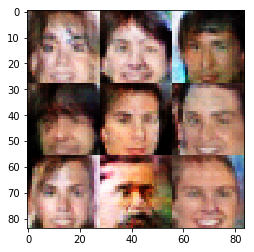

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8061


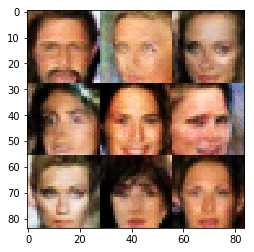

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.7910


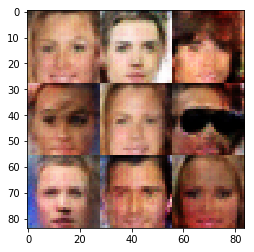

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7946


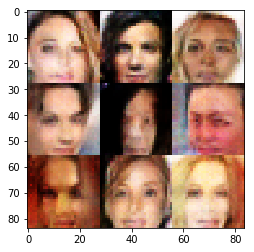

Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7988


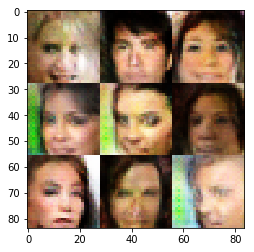

Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.8117


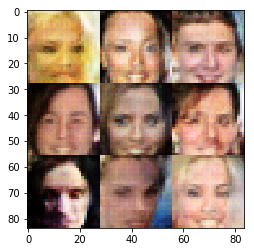

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8176


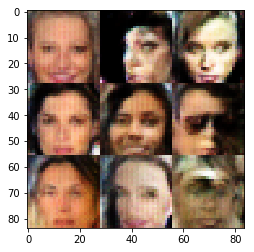

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7922


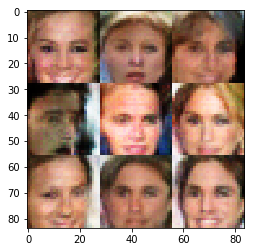

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7967


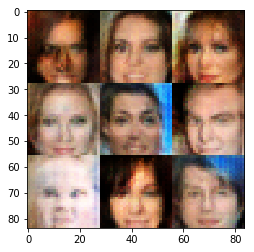

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.7778


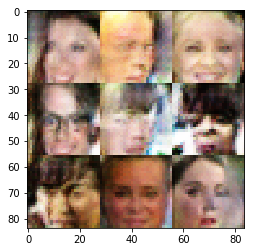

Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7051


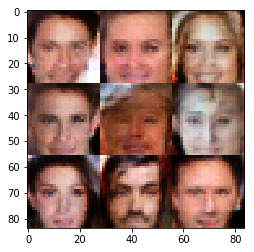

Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7747


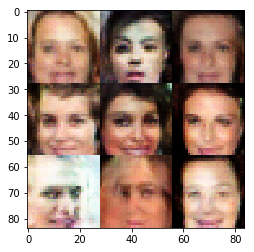

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7706


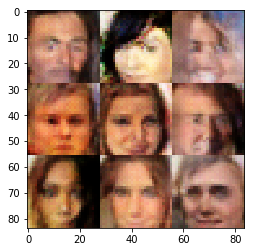

Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7982


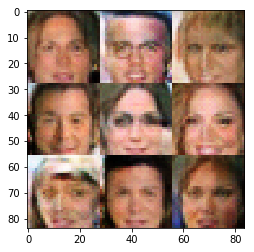

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7690


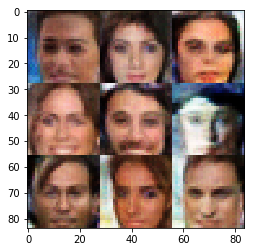

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8217


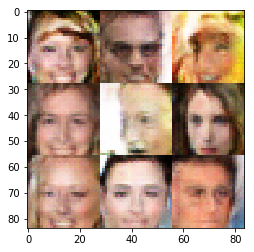

Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.7928


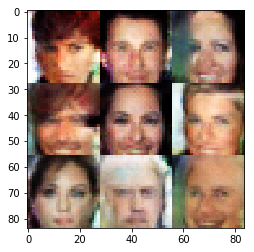

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.3460... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7833


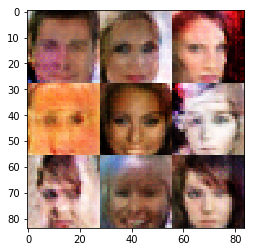

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.7896


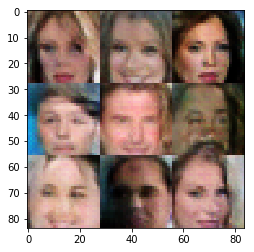

Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.7776


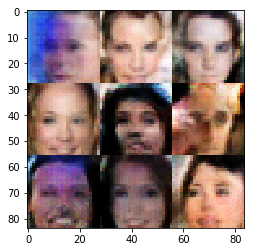

Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7726


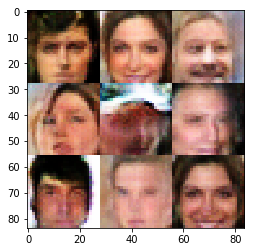

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.7859


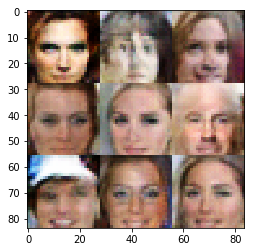

Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7976


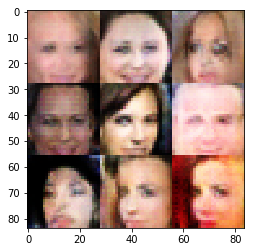

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8048


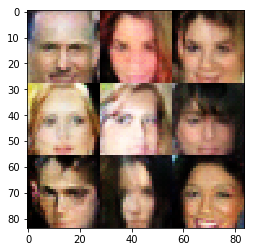

Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8158


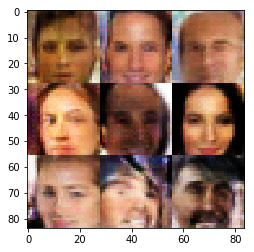

Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7221


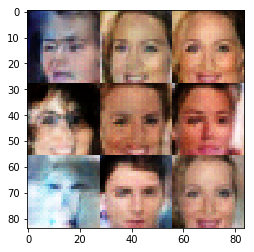

Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7978


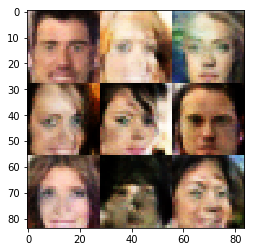

Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7932
Done!


In [28]:
batch_size = 16
z_dim = 100
learning_rate = 0.0008
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.